# Practical: Optimization Algorithms


In [7]:
#Import libraries
import numpy as np
from scipy.optimize import minimize

#Objective function and two constraints
def objective(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    return x1*x4*(x1+x2+x3)+x3

def constraint1(x):
    return x[0]*x[1]*x[2]*x[3]-25.0

def constraint2(x):
    sum_sq = 40
    for i in range(4):
        sum_sq = sum_sq - x[i]**2
    return sum_sq


In [10]:
#Initial guess
x0 = [1,0,5,2]

print(objective(x0))

#setting boundries and constraints
b = (1.0,5.0)
bnds = (b,b,b,b)
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'eq', 'fun': constraint2}
cons = ([con1,con2])

17


In [19]:
#The optimization problem is solved using the SLSQP method as:
solution = minimize(objective,x0,method='SLSQP',bounds=bnds,constraints=cons)
x = solution.x
# show final objective
print('Final Objective: ' + str(objective(x)))

# print solution
print('Solution')
print('x1 = ' + str(x[0]))
print('x2 = ' + str(x[1]))
print('x3 = ' + str(x[2]))
print('x4 = ' + str(x[3]))

Final Objective: 17.014016989977186
Solution
x1 = 1.0
x2 = 4.7429980838345545
x3 = 3.821152061978548
x4 = 1.379407969015844


## Geometry Optimization

In [13]:
from ase import Atoms

# Create a BaTiO3 perovskite crystal
a = 4.0  # Lattice parameter in Angstrom
# BaTiO3 has a perovskite structure with Ba at corners, Ti at center, and O at face centers
symbols = ['Ba', 'Ti', 'O', 'O', 'O']
positions = [
    (0.0, 0.0, 0.0),       # Ba at corner
    (0.5, 0.5, 0.5),       # Ti at body center
    (0.5, 0.5, 0.0),       # O at face centers
    (0.5, 0.0, 0.5),
    (0.0, 0.5, 0.5)
]
atoms = Atoms(symbols=symbols,
           positions=[(x*a, y*a, z*a) for x, y, z in positions],
           cell=[(a, 0, 0), (0, a, 0), (0, 0, a)],
           pbc=True)  # periodic boundary conditions

# Create a supercell
# atoms = atoms.repeat((2, 2, 2))



## Basin Hopping
Basin hopping is a global optimization algorithm that iteratively performs local minimization on a random perturbation of the coordinates of the system. The algorithm is based on the observation that the potential energy surface of a system can be viewed as a landscape of local minima separated by barriers. The algorithm starts with an initial configuration of the system and performs a local minimization to find a local minimum. It then perturbs the coordinates of the system and performs another local minimization. This process is repeated until a stopping criterion is met. The algorithm is called basin hopping because it is like rolling a ball down a hill and hopping from one basin to another.

In [20]:
from scipy.optimize import basinhopping
import numpy as np

func = lambda x: np.cos(14.5 * x - 0.3) + (x + 0.2) * x
x0=[1.]
minimizer_kwargs = {"method": "BFGS"}
basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, niter=200)




                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -1.0008761844426555
                          x: [-1.951e-01]
                        nit: 200
      minimization_failures: 0
                       nfev: 3098
                       njev: 1549
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: -1.0008761844426555
                                    x: [-1.951e-01]
                                  nit: 3
                                  jac: [ 1.565e-06]
                             hess_inv: [[ 4.712e-03]]
                                 nfev: 14
                                 njev: 7

global minimum: x = -0.1951, f(x0) = -1.0009


/var/folders/b4/hm0mlm2x6_g1cbpp4c29f62h0000gn/T/ipykernel_13562/3619970346.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("global minimum: x = %.4f, f(x0) = %.4f" % (ret.x, ret.fun))


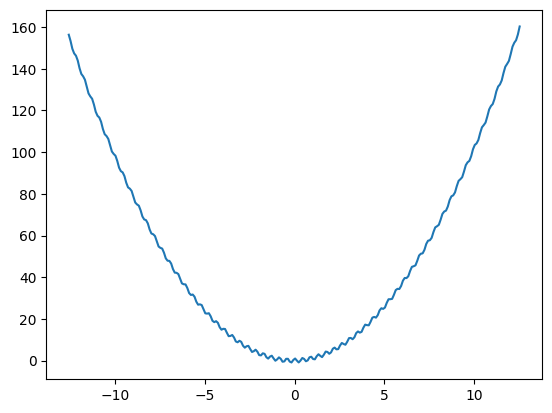

In [22]:
ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, niter=200)
print("global minimum: x = %.4f, f(x0) = %.4f" % (ret.x, ret.fun))

x = np.arange(-4*np.pi,4*np.pi,0.1)   # start,stop,step
y = np.cos(14.5 * x - 0.3) + (x + 0.2) * x
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.show()


In [ ]:
!pip install mace-torch --upgrade

In [15]:
from ase.optimize import LBFGS
import numpy as np
from mace.calculators.foundations_models import mace_mp
from ase.filters import UnitCellFilter

# Add some random displacements to the atoms
rng = np.random.default_rng(42)  # For reproducibility
positions = atoms.get_positions()
displacements = rng.random((len(atoms), 3)) * 0.1  # Random displacements up to 0.1 Å
atoms.set_positions(positions + displacements)

# Set the calculator
atoms.calc = mace_mp(model='medium',device='cpu', dtype='float64')

# Lists to store energy and forces during optimization
energies = []
max_forces = []
volumes = []
# Define a function to collect data at each step
def log_data(atoms=atoms):
    # Record energy and forces
    energies.append(atoms.get_potential_energy())
    forces = atoms.get_forces()
    max_forces.append(np.max(np.abs(forces)))
    
    # Record volume
    volumes.append(atoms.get_cell().volume)
    
# Run the optimization with attached observer
# Setup unit cell filter to optimize both positions and cell
atoms_to_opt = UnitCellFilter(atoms)

# Run the optimization with the filter
dyn = LBFGS(atoms_to_opt)
dyn.attach(log_data)
dyn.run(fmax=0.01)  # Converge until forces are less than 0.01 eV/Å

# Print the optimized energy
print(f"Final energy: {atoms.get_potential_energy()} eV")
print(f"Final forces: {np.max(np.abs(atoms.get_forces()))} eV/Å (max component)")

print(f"Final lattice parameter: {atoms.get_cell_lengths_and_angles()[0]} Å")
print(f"Final volume: {atoms.get_volume()} Å^3")



Using Materials Project MACE for MACECalculator with /Users/zeyudeng/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/zeyudeng/apps/matsci/lib/python3.12/site-packages/mace/calculators/mace.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=de

       Step     Time          Energy          fmax
LBFGS:    0 23:23:53      -39.949074        0.578590
LBFGS:    1 23:23:53      -39.963398        0.492534
LBFGS:    2 23:23:53      -40.003666        0.207855
LBFGS:    3 23:23:53      -40.005711        0.232885
LBFGS:    4 23:23:53      -40.018383        0.267260
LBFGS:    5 23:23:53      -40.023323        0.189266
LBFGS:    6 23:23:54      -40.026997        0.142208
LBFGS:    7 23:23:54      -40.029591        0.107784
LBFGS:    8 23:23:54      -40.030685        0.097366
LBFGS:    9 23:23:54      -40.034306        0.087341
LBFGS:   10 23:23:54      -40.035400        0.092247
LBFGS:   11 23:23:54      -40.036201        0.072455
LBFGS:   12 23:23:54      -40.036747        0.072380
LBFGS:   13 23:23:54      -40.037567        0.068618
LBFGS:   14 23:23:54      -40.038017        0.047601
LBFGS:   15 23:23:54      -40.038200        0.043207
LBFGS:   16 23:23:54      -40.038288        0.034696
LBFGS:   17 23:23:54      -40.038380        0.02

/var/folders/b4/hm0mlm2x6_g1cbpp4c29f62h0000gn/T/ipykernel_11482/757310599.py:42: DeprecationWarning: Please use atoms.cell.cellpar() instead
  print(f"Final lattice parameter: {atoms.get_cell_lengths_and_angles()[0]} Å")


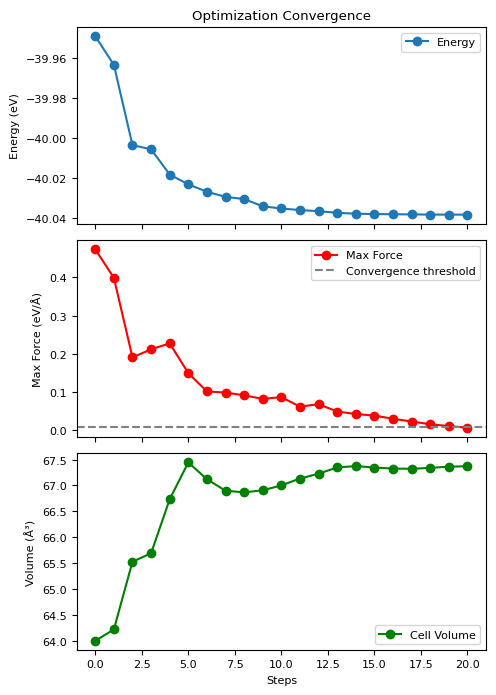

In [16]:
import matplotlib.pyplot as plt

# Plot energy, forces, and volume vs. steps
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

# Plot energy
ax1.plot(energies, 'o-', label='Energy')
# Add experimental value for energy
ax1.set_ylabel('Energy (eV)')
ax1.set_title('Optimization Convergence')
ax1.legend()

# Plot max force
ax2.plot(max_forces, 'o-', color='red', label='Max Force')
ax2.set_ylabel('Max Force (eV/Å)')
ax2.axhline(0.01, color='gray', linestyle='--', label='Convergence threshold')
ax2.legend()

# Plot volume
ax3.plot(volumes, 'o-', color='green', label='Cell Volume')
# Add experimental value for volume
ax3.set_xlabel('Steps')
ax3.set_ylabel('Volume (Å³)')
ax3.legend()

plt.tight_layout()
plt.show()